# neurovoz dataset preprocessing & baseline evaluation

this notebook processes the neurovoz spanish parkinson's speech dataset and establishes clinical baseline performance.

## dataset overview
- **source**: neurovoz spanish pd speech corpus
- **subjects**: 114 total (58 hc, 56 pd)
- **audio files**: ~2,976 recordings
- **tasks**: sustained vowels (a, e, i, o, u × 3 reps), spanish words, free speech
- **metadata**: updrs scale, hoehn & yahr stadium, disease duration, symptoms

## objectives
1. load and verify neurovoz dataset with metadata
2. extract 17 clinical acoustic features (same as italian pvs baseline)
3. train svm baseline with rigorous loso cross-validation
4. generate publication-quality performance figures
5. establish baseline for phase 4 cross-dataset validation

## 1. setup and imports

In [24]:
import sys
from pathlib import Path

# add src to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / 'src'))

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import json
from datetime import datetime
import time

# ml imports
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)
from sklearn.model_selection import LeaveOneGroupOut, cross_val_predict
from sklearn.pipeline import Pipeline

# project imports
from data.datasets import NeuroVozDataset
from features.clinical import ClinicalFeatureExtractor

print("=" * 60)
print("neurovoz preprocessing - setup complete")
print("=" * 60)
print(f"\nproject root: {project_root}")
print(f"python version: {sys.version.split()[0]}")
print(f"working directory: {Path.cwd()}")
print(f"\nlibraries loaded:")
print(f"  - numpy: {np.__version__}")
print(f"  - pandas: {pd.__version__}")
print(f"  - sklearn: {__import__('sklearn').__version__}")
print(f"  - tqdm: ready for progress bars")
print("=" * 60)

neurovoz preprocessing - setup complete

project root: /Volumes/usb drive/pd-interpretability
python version: 3.12.12
working directory: /Volumes/usb drive/pd-interpretability/notebooks

libraries loaded:
  - numpy: 1.26.4
  - pandas: 2.3.3
  - sklearn: 1.3.2
  - tqdm: ready for progress bars


In [25]:
# configuration - all lowercase, nonchalant style
config = {
    'data_dir': project_root / 'data' / 'raw' / 'neurovoz',
    'features_dir': project_root / 'data' / 'clinical_features',
    'results_dir': project_root / 'results' / 'neurovoz_baseline',
    'task': None,  # none = all tasks for comprehensive evaluation
    'svm_params': {
        'kernel': 'rbf',
        'c': 1.0,
        'gamma': 'scale',
        'random_state': 42
    },
    'max_folds': None,  # none = all subjects (rigorous evaluation)
    'seed': 42
}

# create directories
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
config['results_dir'] = config['results_dir'] / f"run_{timestamp}"
config['results_dir'].mkdir(parents=True, exist_ok=True)
config['features_dir'].mkdir(parents=True, exist_ok=True)

print("=" * 60)
print("configuration")
print("=" * 60)
print(f"\ndata paths:")
print(f"  data_dir:     {config['data_dir']}")
print(f"  features_dir: {config['features_dir']}")
print(f"  results_dir:  {config['results_dir']}")
print(f"\nmodel settings:")
print(f"  task filter: {config['task']} (none = all tasks)")
print(f"  svm kernel:  {config['svm_params']['kernel']}")
print(f"  svm c:       {config['svm_params']['c']}")
print(f"  svm gamma:   {config['svm_params']['gamma']}")
print(f"  random seed: {config['seed']}")
print(f"\ntimestamp: {timestamp}")
print("=" * 60)

configuration

data paths:
  data_dir:     /Volumes/usb drive/pd-interpretability/data/raw/neurovoz
  features_dir: /Volumes/usb drive/pd-interpretability/data/clinical_features
  results_dir:  /Volumes/usb drive/pd-interpretability/results/neurovoz_baseline/run_20260104_204155

model settings:
  task filter: None (none = all tasks)
  svm kernel:  rbf
  svm c:       1.0
  svm gamma:   scale
  random seed: 42

timestamp: 20260104_204155


## 2. dataset loading and verification

In [26]:
# load dataset with verbose logging
print("=" * 60)
print("step 1: loading neurovoz dataset")
print("=" * 60)
print(f"\nloading from: {config['data_dir']}")
print(f"task filter: {config['task']}")

start_time = time.time()

dataset = NeuroVozDataset(
    root_dir=config['data_dir'],
    task=config['task']
)

load_time = time.time() - start_time

print(f"\n✓ dataset loaded successfully in {load_time:.2f}s")
print(f"\nstats:")
print(f"  total samples:   {len(dataset):,}")
print(f"  unique subjects: {dataset.n_subjects}")
print(f"  subject ids:     {len(dataset.subject_ids)}")
print("=" * 60)

step 1: loading neurovoz dataset

loading from: /Volumes/usb drive/pd-interpretability/data/raw/neurovoz
task filter: None

✓ dataset loaded successfully in 4.07s

stats:
  total samples:   2,976
  unique subjects: 114
  subject ids:     114


In [27]:
# verify dataset distribution with detailed logging
print("=" * 60)
print("step 2: verifying dataset distribution")
print("=" * 60)

labels = [dataset.samples[i]['label'] for i in tqdm(range(len(dataset)), desc="extracting labels")]
subject_ids = [dataset.samples[i]['subject_id'] for i in range(len(dataset))]

label_counts = pd.Series(labels).value_counts()
print(f"\nlabel distribution:")
print(f"  hc (0): {label_counts.get(0, 0):,} samples")
print(f"  pd (1): {label_counts.get(1, 0):,} samples")
print(f"  balance: {label_counts.get(1, 0) / len(labels) * 100:.1f}% pd")

# count unique subjects per class
subject_labels = {}
for sid, label in zip(subject_ids, labels):
    subject_labels[sid] = label

hc_subjects = sum(1 for v in subject_labels.values() if v == 0)
pd_subjects = sum(1 for v in subject_labels.values() if v == 1)

print(f"\nsubject distribution:")
print(f"  hc subjects: {hc_subjects}")
print(f"  pd subjects: {pd_subjects}")
print(f"  total:       {len(subject_labels)}")

# task distribution
tasks = [dataset.samples[i]['task'] for i in range(len(dataset))]
task_counts = pd.Series(tasks).value_counts()
print(f"\ntask distribution:")
for task, count in task_counts.head(10).items():
    print(f"  {task}: {count}")
if len(task_counts) > 10:
    print(f"  ... and {len(task_counts) - 10} more tasks")
print("=" * 60)

step 2: verifying dataset distribution


extracting labels:   0%|          | 0/2976 [00:00<?, ?it/s]


label distribution:
  hc (0): 1,509 samples
  pd (1): 1,467 samples
  balance: 49.3% pd

subject distribution:
  hc subjects: 58
  pd subjects: 56
  total:       114

task distribution:
  vowel_a1: 111
  vowel_i1: 111
  acampada: 110
  manga: 110
  ganga: 110
  patata_blanda: 109
  pan_vino: 109
  perro: 109
  burro: 109
  petaca_blanca: 108
  ... and 23 more tasks


In [28]:
# inspect sample metadata
print("=" * 60)
print("sample metadata inspection")
print("=" * 60)
print("\nfirst 3 samples:")
for i in range(min(3, len(dataset))):
    sample = dataset.samples[i]
    print(f"\n[sample {i}]")
    for key, value in sample.items():
        if key == 'path':
            print(f"  {key}: .../{Path(value).name}")
        else:
            print(f"  {key}: {value}")
print("\n" + "=" * 60)

sample metadata inspection

first 3 samples:

[sample 0]
  path: .../HC_A1_0034.wav
  label: 0
  subject_id: HC_0034
  task: vowel_a1
  diagnosis: HC
  subject_number: 34
  age: 77.0
  sex: 1
  vocal_tremor: 0
  cephalic_tremor: 0
  mandibular_tremor: 0
  sialorrhoea: 0
  dysphagia: 0
  hypophonic_voice: 0

[sample 1]
  path: .../HC_A1_0036.wav
  label: 0
  subject_id: HC_0036
  task: vowel_a1
  diagnosis: HC
  subject_number: 36
  age: 59.0
  sex: 0
  vocal_tremor: 0
  cephalic_tremor: 0
  mandibular_tremor: 0
  sialorrhoea: 0
  dysphagia: 0
  hypophonic_voice: 0

[sample 2]
  path: .../HC_A1_0045.wav
  label: 0
  subject_id: HC_0045
  task: vowel_a1
  diagnosis: HC
  subject_number: 45
  age: 56.0
  sex: 1
  vocal_tremor: 0
  cephalic_tremor: 0
  mandibular_tremor: 0
  sialorrhoea: 0
  dysphagia: 0
  hypophonic_voice: 0



## 3. clinical feature extraction

extract 17 clinical acoustic features using parselmouth (same as italian pvs baseline):

### feature list:
- **pitch** (5): f0_mean, f0_std, f0_min, f0_max, f0_range
- **voicing** (1): voicing_fraction
- **jitter** (4): jitter_local, jitter_rap, jitter_ppq5, jitter_ddp
- **shimmer** (5): shimmer_local, shimmer_apq3, shimmer_apq5, shimmer_apq11, shimmer_dda
- **hnr** (2): hnr_mean, hnr_std

In [29]:
# check if features already extracted, load or extract
print("=" * 60)
print("step 3: clinical feature extraction")
print("=" * 60)

# determine csv path based on task filter
if config['task'] is None:
    features_csv_path = config['features_dir'] / 'neurovoz_features_all_tasks.csv'
else:
    task_str = '_'.join(config['task']) if isinstance(config['task'], list) else config['task']
    features_csv_path = config['features_dir'] / f'neurovoz_features_{task_str}.csv'

print(f"\nfeatures csv path: {features_csv_path}")

if features_csv_path.exists():
    print(f"✓ found existing features file, loading...")
    start_time = time.time()
    features_df = pd.read_csv(features_csv_path)
    load_time = time.time() - start_time
    print(f"✓ loaded {len(features_df):,} samples in {load_time:.2f}s")
    print(f"  columns: {len(features_df.columns)}")
else:
    print("extracting clinical features for all samples...")
    print("this may take several minutes.\n")
    
    extractor = ClinicalFeatureExtractor(
        f0_min=75.0,
        f0_max=600.0
    )
    
    features_list = []
    failed_samples = []
    
    start_time = time.time()
    for i in tqdm(range(len(dataset)), desc="extracting features", unit="sample"):
        sample = dataset.samples[i]
        
        try:
            features = extractor.extract(str(sample['path']))
            
            features['sample_idx'] = i
            features['path'] = str(sample['path'])
            features['subject_id'] = sample['subject_id']
            features['label'] = sample['label']
            features['diagnosis'] = 'pd' if sample['label'] == 1 else 'hc'
            features['task'] = sample['task']
            
            # add clinical metadata if available
            for key in ['age', 'sex', 'updrs', 'hy_stadium', 'disease_duration']:
                if key in sample:
                    features[key] = sample[key]
            
            features_list.append(features)
            
        except Exception as e:
            failed_samples.append((i, str(e)))
    
    extract_time = time.time() - start_time
    features_df = pd.DataFrame(features_list)
    
    print(f"\n✓ extraction complete in {extract_time:.1f}s")
    print(f"  extracted: {len(features_df):,} samples")
    print(f"  failed:    {len(failed_samples)} samples")
    print(f"  rate:      {len(features_df)/extract_time:.1f} samples/sec")
    
    if failed_samples:
        print(f"\nfirst 5 failures:")
        for idx, error in failed_samples[:5]:
            print(f"  sample {idx}: {error[:50]}...")
    
    # save to csv
    features_df.to_csv(features_csv_path, index=False)
    print(f"\n✓ saved to {features_csv_path}")

print("=" * 60)

step 3: clinical feature extraction

features csv path: /Volumes/usb drive/pd-interpretability/data/clinical_features/neurovoz_features_all_tasks.csv
✓ found existing features file, loading...
✓ loaded 2,650 samples in 0.22s
  columns: 40


In [30]:
# define the 17 clinical features (same as italian pvs baseline)
clinical_feature_cols = [
    'f0_mean', 'f0_std', 'f0_min', 'f0_max', 'f0_range',
    'voicing_fraction',
    'jitter_local', 'jitter_rap', 'jitter_ppq5', 'jitter_ddp',
    'shimmer_local', 'shimmer_apq3', 'shimmer_apq5', 'shimmer_apq11', 'shimmer_dda',
    'hnr_mean', 'hnr_std'
]

available_features = [f for f in clinical_feature_cols if f in features_df.columns]

print("=" * 60)
print("feature statistics")
print("=" * 60)
print(f"\navailable clinical features: {len(available_features)}/17")
for i, f in enumerate(available_features):
    print(f"  {i+1:2d}. {f}")

print("\nfeature summary:")
print(features_df[available_features].describe().T[['mean', 'std', 'min', 'max']])
print("=" * 60)

feature statistics

available clinical features: 17/17
   1. f0_mean
   2. f0_std
   3. f0_min
   4. f0_max
   5. f0_range
   6. voicing_fraction
   7. jitter_local
   8. jitter_rap
   9. jitter_ppq5
  10. jitter_ddp
  11. shimmer_local
  12. shimmer_apq3
  13. shimmer_apq5
  14. shimmer_apq11
  15. shimmer_dda
  16. hnr_mean
  17. hnr_std

feature summary:
                        mean         std        min         max
f0_mean           160.937246   41.059291  78.143314  507.669351
f0_std             27.920325   29.184928   0.523917  240.664360
f0_min            115.252415   42.830175  57.233948  487.955848
f0_max            281.058762  162.087156  80.202769  613.223675
f0_range          165.493506  175.546710   0.000000  535.988599
voicing_fraction    0.775084    0.220608   0.000000    1.000000
jitter_local        0.016473    0.011898   0.000858    0.089825
jitter_rap          0.007326    0.005584   0.000336    0.057379
jitter_ppq5         0.008054    0.005875   0.000479    0.058449


In [31]:
# check for missing values
print("=" * 60)
print("data cleaning")
print("=" * 60)

print("\nmissing values per feature:")
missing = features_df[available_features].isnull().sum()
if missing.sum() > 0:
    for feat, count in missing[missing > 0].items():
        print(f"  {feat}: {count} missing")
else:
    print("  none - all features complete ✓")

# drop rows with any missing clinical features
n_before = len(features_df)
features_clean = features_df.dropna(subset=available_features)
n_after = len(features_clean)
n_dropped = n_before - n_after

print(f"\nsamples before cleaning: {n_before:,}")
print(f"samples after cleaning:  {n_after:,}")
print(f"dropped:                 {n_dropped} ({n_dropped/n_before*100:.1f}%)")
print("=" * 60)

data cleaning

missing values per feature:
  f0_mean: 5 missing
  f0_std: 5 missing
  f0_min: 5 missing
  f0_max: 5 missing
  jitter_local: 5 missing
  jitter_rap: 5 missing
  jitter_ppq5: 5 missing
  jitter_ddp: 5 missing
  shimmer_local: 5 missing
  shimmer_apq3: 5 missing
  shimmer_apq5: 7 missing
  shimmer_apq11: 19 missing
  shimmer_dda: 5 missing

samples before cleaning: 2,650
samples after cleaning:  2,631
dropped:                 19 (0.7%)


## 4. svm baseline training with loso cross-validation

train svm classifier using leave-one-subject-out (loso) cross-validation:
- each fold: train on n-1 subjects, test on 1 held-out subject
- prevents data leakage (critical for medical ml)
- evaluates generalization to unseen individuals

In [32]:
# prepare feature matrix and labels
print("=" * 60)
print("step 4: preparing feature matrix")
print("=" * 60)

x = features_clean[available_features].values
y = features_clean['label'].values
groups = features_clean['subject_id'].values

print(f"\nfeature matrix shape: {x.shape}")
print(f"  samples:  {x.shape[0]:,}")
print(f"  features: {x.shape[1]}")
print(f"\nlabels shape: {y.shape}")
print(f"  hc (0): {(y == 0).sum():,}")
print(f"  pd (1): {(y == 1).sum():,}")
print(f"\nunique subjects: {len(np.unique(groups))}")
print("=" * 60)

step 4: preparing feature matrix

feature matrix shape: (2631, 17)
  samples:  2,631
  features: 17

labels shape: (2631,)
  hc (0): 1,322
  pd (1): 1,309

unique subjects: 114


In [33]:
# loso cross-validation setup
print("=" * 60)
print("loso cross-validation setup")
print("=" * 60)

logo = LeaveOneGroupOut()
n_folds = logo.get_n_splits(x, y, groups)

print(f"\ncv method: leave-one-subject-out")
print(f"number of folds: {n_folds}")
print(f"\nsvm parameters:")
print(f"  kernel: {config['svm_params']['kernel']}")
print(f"  c:      {config['svm_params']['c']}")
print(f"  gamma:  {config['svm_params']['gamma']}")
print("=" * 60)

loso cross-validation setup

cv method: leave-one-subject-out
number of folds: 114

svm parameters:
  kernel: rbf
  c:      1.0
  gamma:  scale


In [34]:
# train svm with loso cv - verbose with tqdm progress
print("=" * 60)
print("step 5: training svm with loso cv")
print("=" * 60)

# fix the key name for SVC
svm_params_fixed = {
    'kernel': config['svm_params']['kernel'],
    'C': config['svm_params']['c'],  # sklearn expects uppercase C
    'gamma': config['svm_params']['gamma'],
    'random_state': config['svm_params']['random_state'],
    'probability': True
}

svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(**svm_params_fixed))
])

print(f"\nrunning {n_folds}-fold loso cross-validation...")
print(f"this may take a few minutes.\n")

start_time = time.time()

# get predictions for all samples
y_pred = cross_val_predict(svm_pipeline, x, y, cv=logo, groups=groups)
y_proba = cross_val_predict(svm_pipeline, x, y, cv=logo, groups=groups, method='predict_proba')[:, 1]

train_time = time.time() - start_time

print(f"✓ loso cross-validation complete!")
print(f"  time elapsed: {train_time:.1f}s")
print(f"  folds tested: {n_folds}")
print(f"  predictions:  {len(y_pred):,}")
print("=" * 60)

step 5: training svm with loso cv

running 114-fold loso cross-validation...
this may take a few minutes.

✓ loso cross-validation complete!
  time elapsed: 681.3s
  folds tested: 114
  predictions:  2,631


In [35]:
# calculate aggregate metrics
metrics = {
    'accuracy': accuracy_score(y, y_pred),
    'precision': precision_score(y, y_pred, average='binary'),
    'recall': recall_score(y, y_pred, average='binary'),
    'f1': f1_score(y, y_pred, average='binary'),
    'auc': roc_auc_score(y, y_proba),
    'n_folds': n_folds,
    'n_samples': len(y),
    'n_subjects': len(np.unique(groups))
}

# confusion matrix
cm = confusion_matrix(y, y_pred)
tn, fp, fn, tp = cm.ravel()

metrics['confusion_matrix'] = {
    'tn': int(tn), 'fp': int(fp),
    'fn': int(fn), 'tp': int(tp)
}

metrics['sensitivity'] = tp / (tp + fn) if (tp + fn) > 0 else 0
metrics['specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0

print("\n" + "=" * 60)
print("NEUROVOZ BASELINE RESULTS")
print("=" * 60)
print(f"\ndataset: neurovoz spanish pd corpus")
print(f"task:    {config['task']} (all tasks)")
print(f"model:   svm (rbf kernel)")
print(f"cv:      loso ({n_folds} folds)")
print(f"\nsamples:")
print(f"  total:   {metrics['n_samples']:,}")
print(f"  hc:      {tn + fp:,}")
print(f"  pd:      {tp + fn:,}")
print(f"\nperformance metrics:")
print(f"  accuracy:    {metrics['accuracy']:.1%}")
print(f"  precision:   {metrics['precision']:.1%}")
print(f"  recall:      {metrics['recall']:.1%}")
print(f"  f1 score:    {metrics['f1']:.3f}")
print(f"  auc-roc:     {metrics['auc']:.3f}")
print(f"  sensitivity: {metrics['sensitivity']:.1%}")
print(f"  specificity: {metrics['specificity']:.1%}")
print(f"\nconfusion matrix:")
print(f"           predicted")
print(f"           hc    pd")
print(f"  true hc  {tn:4d}  {fp:4d}")
print(f"  true pd  {fn:4d}  {tp:4d}")
print("=" * 60)


NEUROVOZ BASELINE RESULTS

dataset: neurovoz spanish pd corpus
task:    None (all tasks)
model:   svm (rbf kernel)
cv:      loso (114 folds)

samples:
  total:   2,631
  hc:      1,322
  pd:      1,309

performance metrics:
  accuracy:    63.0%
  precision:   63.1%
  recall:      61.7%
  f1 score:    0.624
  auc-roc:     0.686
  sensitivity: 61.7%
  specificity: 64.4%

confusion matrix:
           predicted
           hc    pd
  true hc   851   471
  true pd   502   807


In [36]:
# per-subject accuracy analysis with tqdm
print("=" * 60)
print("per-subject accuracy analysis")
print("=" * 60)

unique_subjects = np.unique(groups)
subject_results = []

for subject in tqdm(unique_subjects, desc="analyzing subjects"):
    mask = groups == subject
    subject_true = y[mask]
    subject_pred = y_pred[mask]
    
    subject_acc = accuracy_score(subject_true, subject_pred)
    subject_label = 'pd' if subject_true[0] == 1 else 'hc'
    n_samples = mask.sum()
    
    subject_results.append({
        'subject_id': subject,
        'diagnosis': subject_label,
        'n_samples': n_samples,
        'accuracy': subject_acc,
        'correct': int(subject_acc * n_samples),
        'total': n_samples
    })

subject_accuracy_df = pd.DataFrame(subject_results)

print(f"\nper-subject summary:")
print(f"  total subjects: {len(subject_accuracy_df)}")
print(f"  mean accuracy:  {subject_accuracy_df['accuracy'].mean():.1%}")
print(f"  std accuracy:   {subject_accuracy_df['accuracy'].std():.3f}")
print(f"\nsubjects by accuracy:")
print(f"  100% correct: {(subject_accuracy_df['accuracy'] == 1.0).sum()}")
print(f"  >75% correct: {(subject_accuracy_df['accuracy'] > 0.75).sum()}")
print(f"  >50% correct: {(subject_accuracy_df['accuracy'] > 0.50).sum()}")
print(f"  0% correct:   {(subject_accuracy_df['accuracy'] == 0.0).sum()}")
print(f"\nsample of results:")
print(subject_accuracy_df[['subject_id', 'diagnosis', 'n_samples', 'accuracy']].head(10).to_string(index=False))
print("=" * 60)

per-subject accuracy analysis


analyzing subjects:   0%|          | 0/114 [00:00<?, ?it/s]


per-subject summary:
  total subjects: 114
  mean accuracy:  62.4%
  std accuracy:   0.227

subjects by accuracy:
  100% correct: 4
  >75% correct: 37
  >50% correct: 83
  0% correct:   2

sample of results:
subject_id diagnosis  n_samples  accuracy
   HC_0034        hc         27  0.185185
   HC_0036        hc         21  0.190476
   HC_0045        hc         22  0.727273
   HC_0048        hc         21  0.714286
   HC_0049        hc         23  0.565217
   HC_0051        hc         23  0.782609
   HC_0052        hc         22  0.636364
   HC_0053        hc         23  0.826087
   HC_0054        hc         22  0.590909
   HC_0055        hc         23  0.869565


## 5. generate publication-quality figures

In [37]:
# set publication style
print("=" * 60)
print("step 6: setting up publication figure style")
print("=" * 60)

plt.style.use('default')
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'font.size': 10,
    'axes.labelsize': 10,
    'axes.titlesize': 11,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.titlesize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1
})

print(f"\nstyle configured:")
print(f"  font:       serif (times new roman)")
print(f"  dpi:        300 (publication quality)")
print(f"  output dir: {config['results_dir']}")
print("=" * 60)

step 6: setting up publication figure style

style configured:
  font:       serif (times new roman)
  dpi:        300 (publication quality)
  output dir: /Volumes/usb drive/pd-interpretability/results/neurovoz_baseline/run_20260104_204155


generating figure 1: confusion matrix...


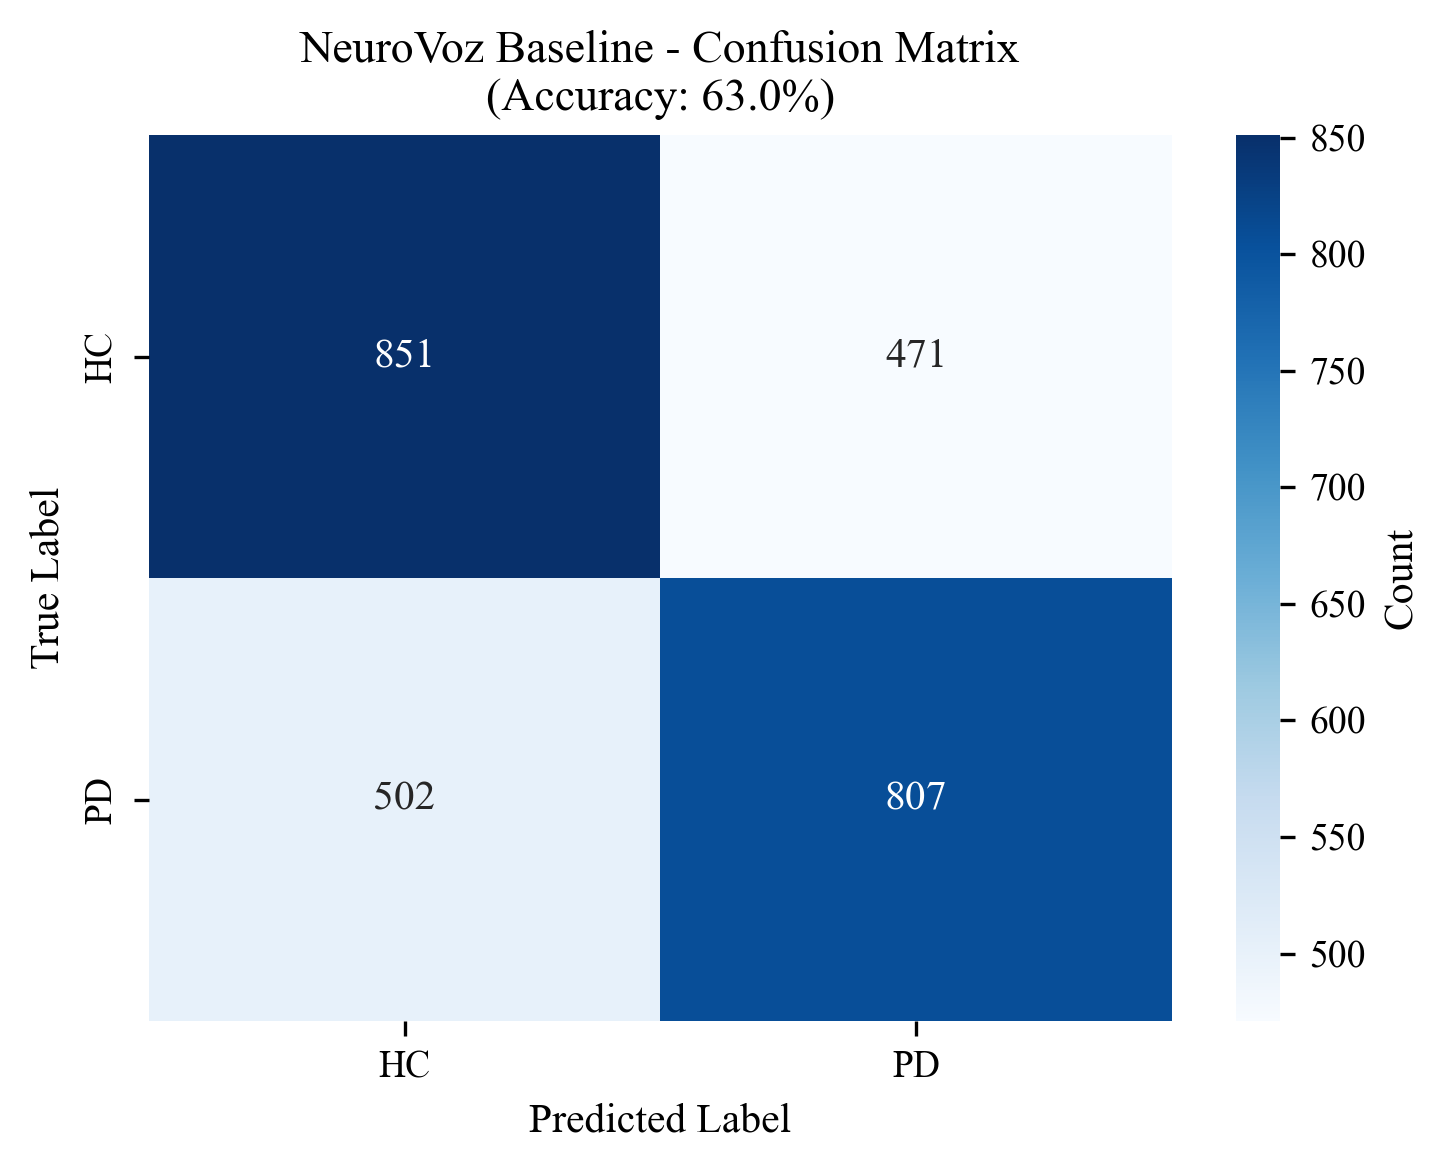

✓ saved confusion_matrix.png and .pdf


In [38]:
# figure 1: confusion matrix
print("generating figure 1: confusion matrix...")

fig, ax = plt.subplots(figsize=(5, 4))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['HC', 'PD'],
            yticklabels=['HC', 'PD'],
            cbar_kws={'label': 'Count'},
            ax=ax)

ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title(f'NeuroVoz Baseline - Confusion Matrix\n(Accuracy: {metrics["accuracy"]:.1%})')

plt.tight_layout()
plt.savefig(config['results_dir'] / 'confusion_matrix.png', dpi=300)
plt.savefig(config['results_dir'] / 'confusion_matrix.pdf')
plt.show()

print(f"✓ saved confusion_matrix.png and .pdf")

generating figure 2: roc curve...


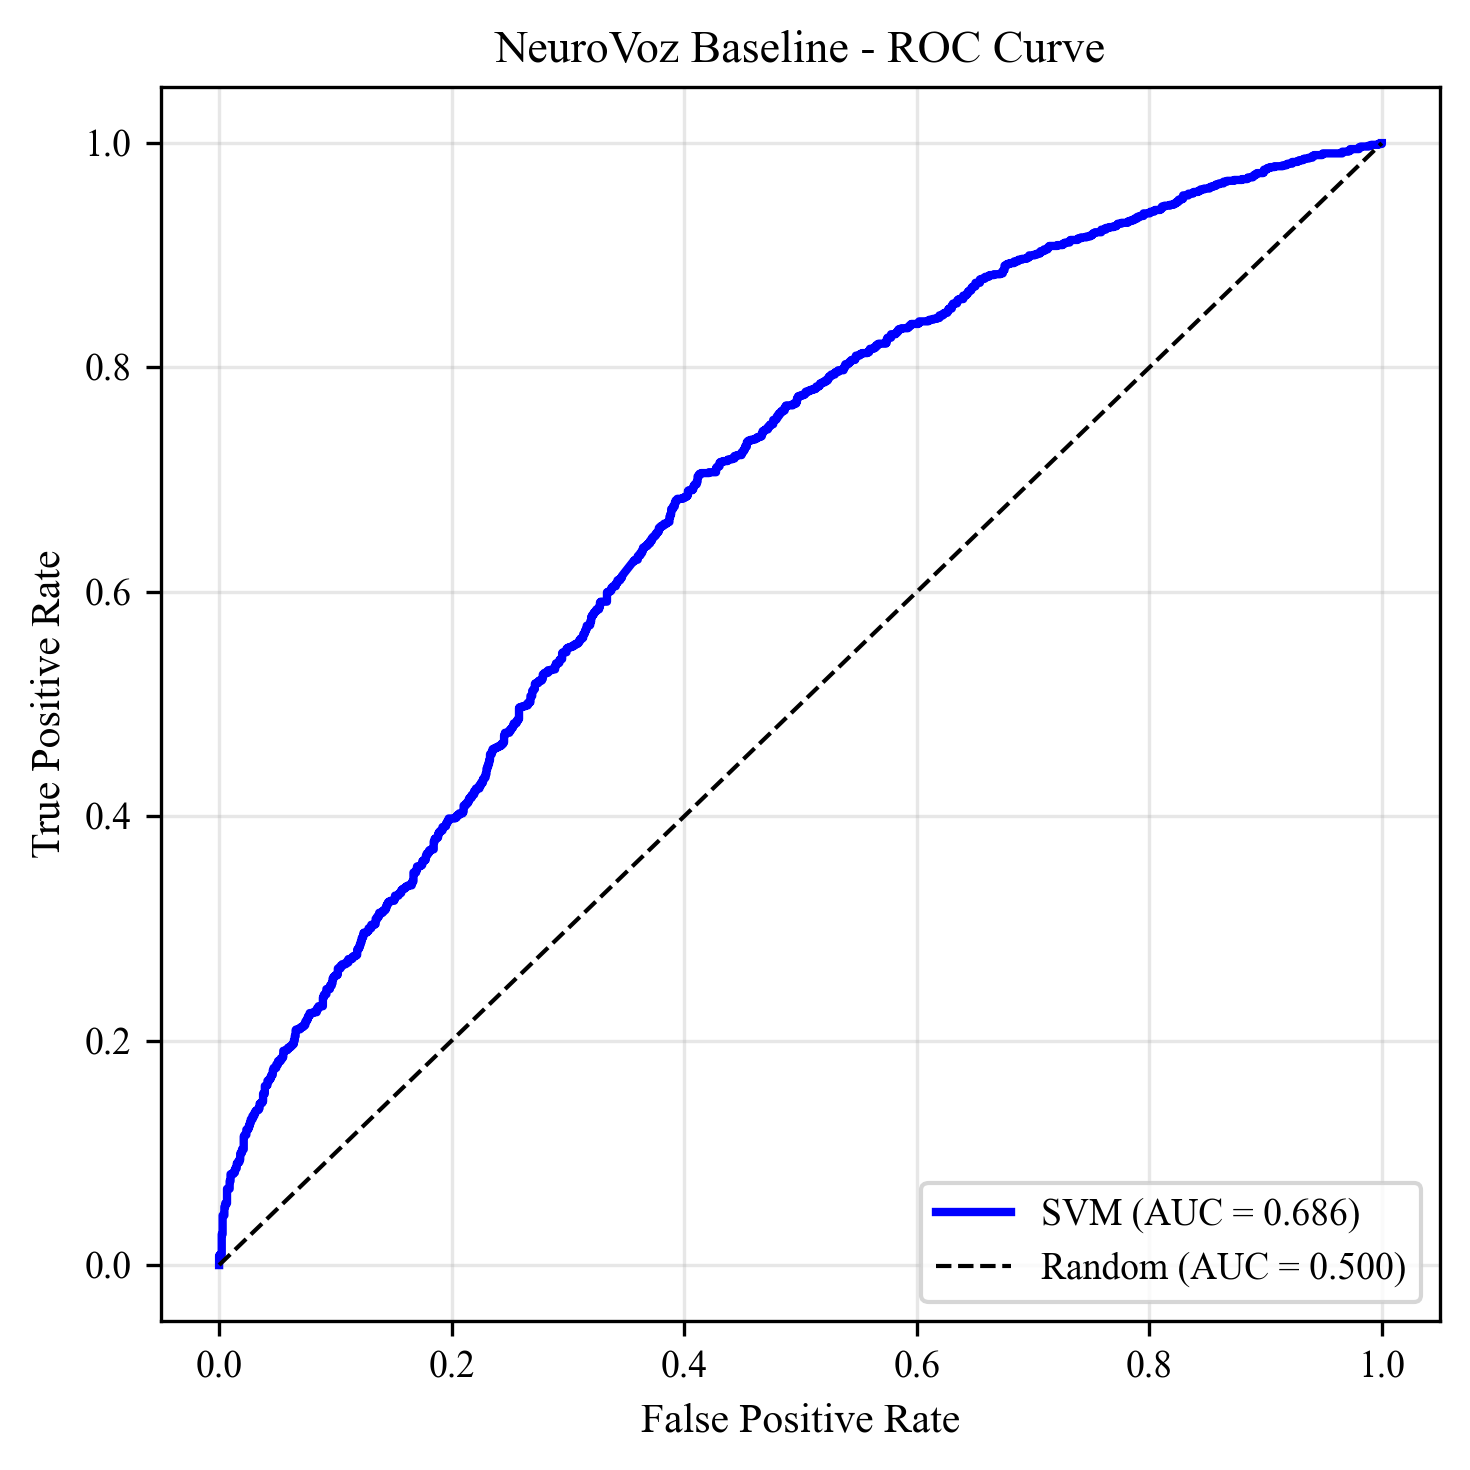

✓ saved roc_curve.png and .pdf


In [39]:
# figure 2: roc curve
print("generating figure 2: roc curve...")

fpr, tpr, thresholds = roc_curve(y, y_proba)

fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(fpr, tpr, 'b-', linewidth=2, label=f'SVM (AUC = {metrics["auc"]:.3f})')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random (AUC = 0.500)')

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('NeuroVoz Baseline - ROC Curve')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])

plt.tight_layout()
plt.savefig(config['results_dir'] / 'roc_curve.png', dpi=300)
plt.savefig(config['results_dir'] / 'roc_curve.pdf')
plt.show()

print(f"✓ saved roc_curve.png and .pdf")

generating figure 3: per-subject accuracy distribution...


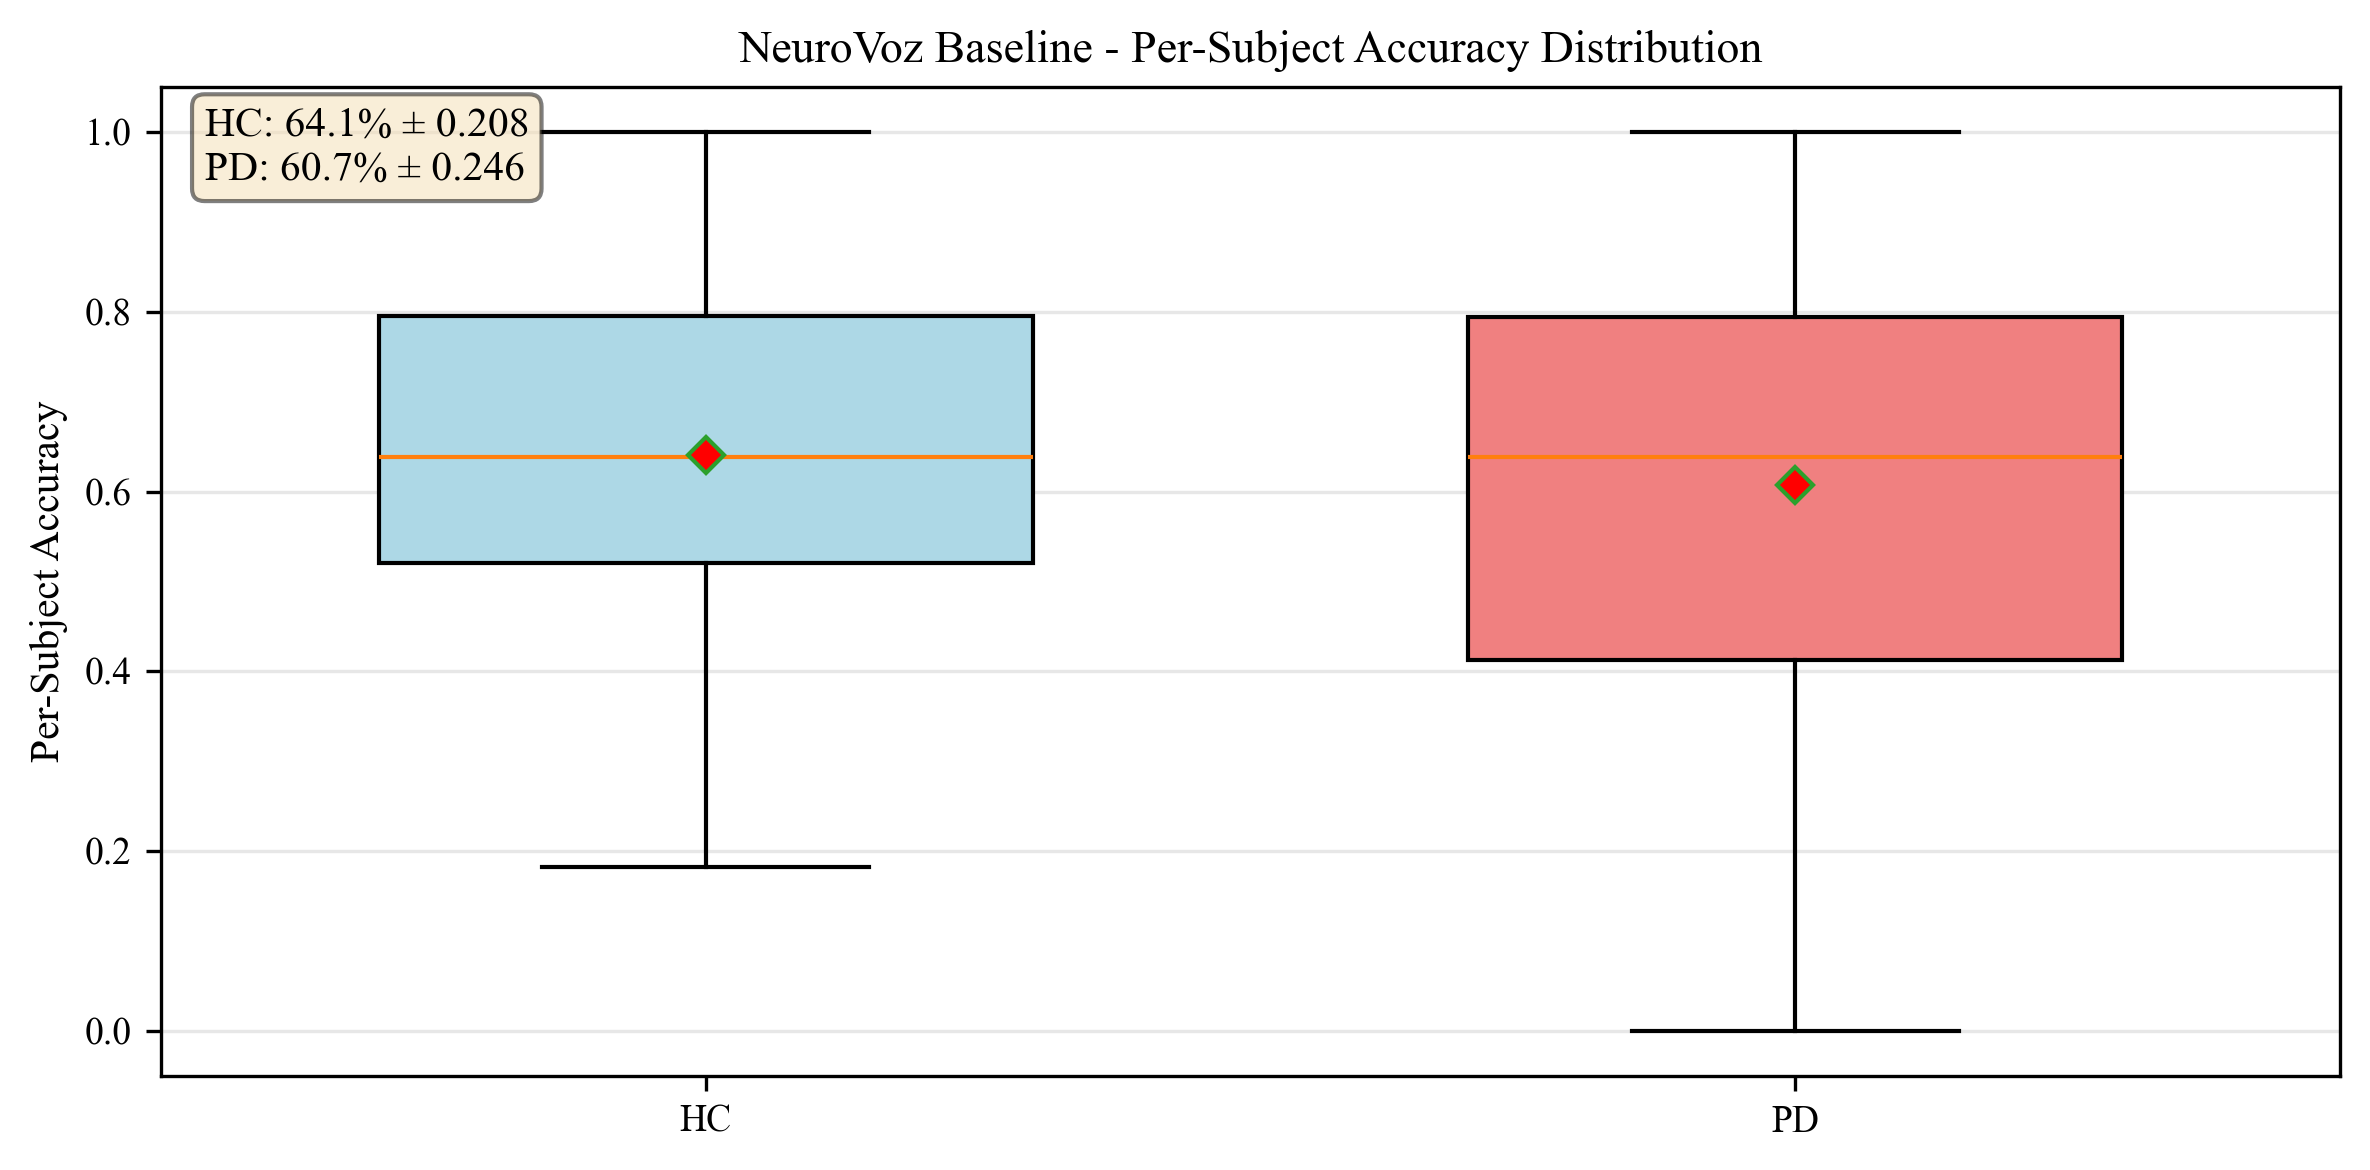

✓ saved per_subject_accuracy.png and .pdf


In [40]:
# figure 3: per-subject accuracy distribution
print("generating figure 3: per-subject accuracy distribution...")

fig, ax = plt.subplots(figsize=(8, 4))

# separate by class
hc_acc = subject_accuracy_df[subject_accuracy_df['diagnosis'] == 'hc']['accuracy']
pd_acc = subject_accuracy_df[subject_accuracy_df['diagnosis'] == 'pd']['accuracy']

positions = [1, 2]
box_data = [hc_acc, pd_acc]
bp = ax.boxplot(box_data, positions=positions, widths=0.6,
                patch_artist=True, showmeans=True,
                meanprops=dict(marker='D', markerfacecolor='red', markersize=6))

# color boxes
colors = ['lightblue', 'lightcoral']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_xticks(positions)
ax.set_xticklabels(['HC', 'PD'])
ax.set_ylabel('Per-Subject Accuracy')
ax.set_title('NeuroVoz Baseline - Per-Subject Accuracy Distribution')
ax.grid(True, axis='y', alpha=0.3)
ax.set_ylim([-0.05, 1.05])

# add statistics
stats_text = f"HC: {hc_acc.mean():.1%} ± {hc_acc.std():.3f}\n"
stats_text += f"PD: {pd_acc.mean():.1%} ± {pd_acc.std():.3f}"
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(config['results_dir'] / 'per_subject_accuracy.png', dpi=300)
plt.savefig(config['results_dir'] / 'per_subject_accuracy.pdf')
plt.show()

print(f"✓ saved per_subject_accuracy.png and .pdf")

generating figure 4: performance metrics summary...


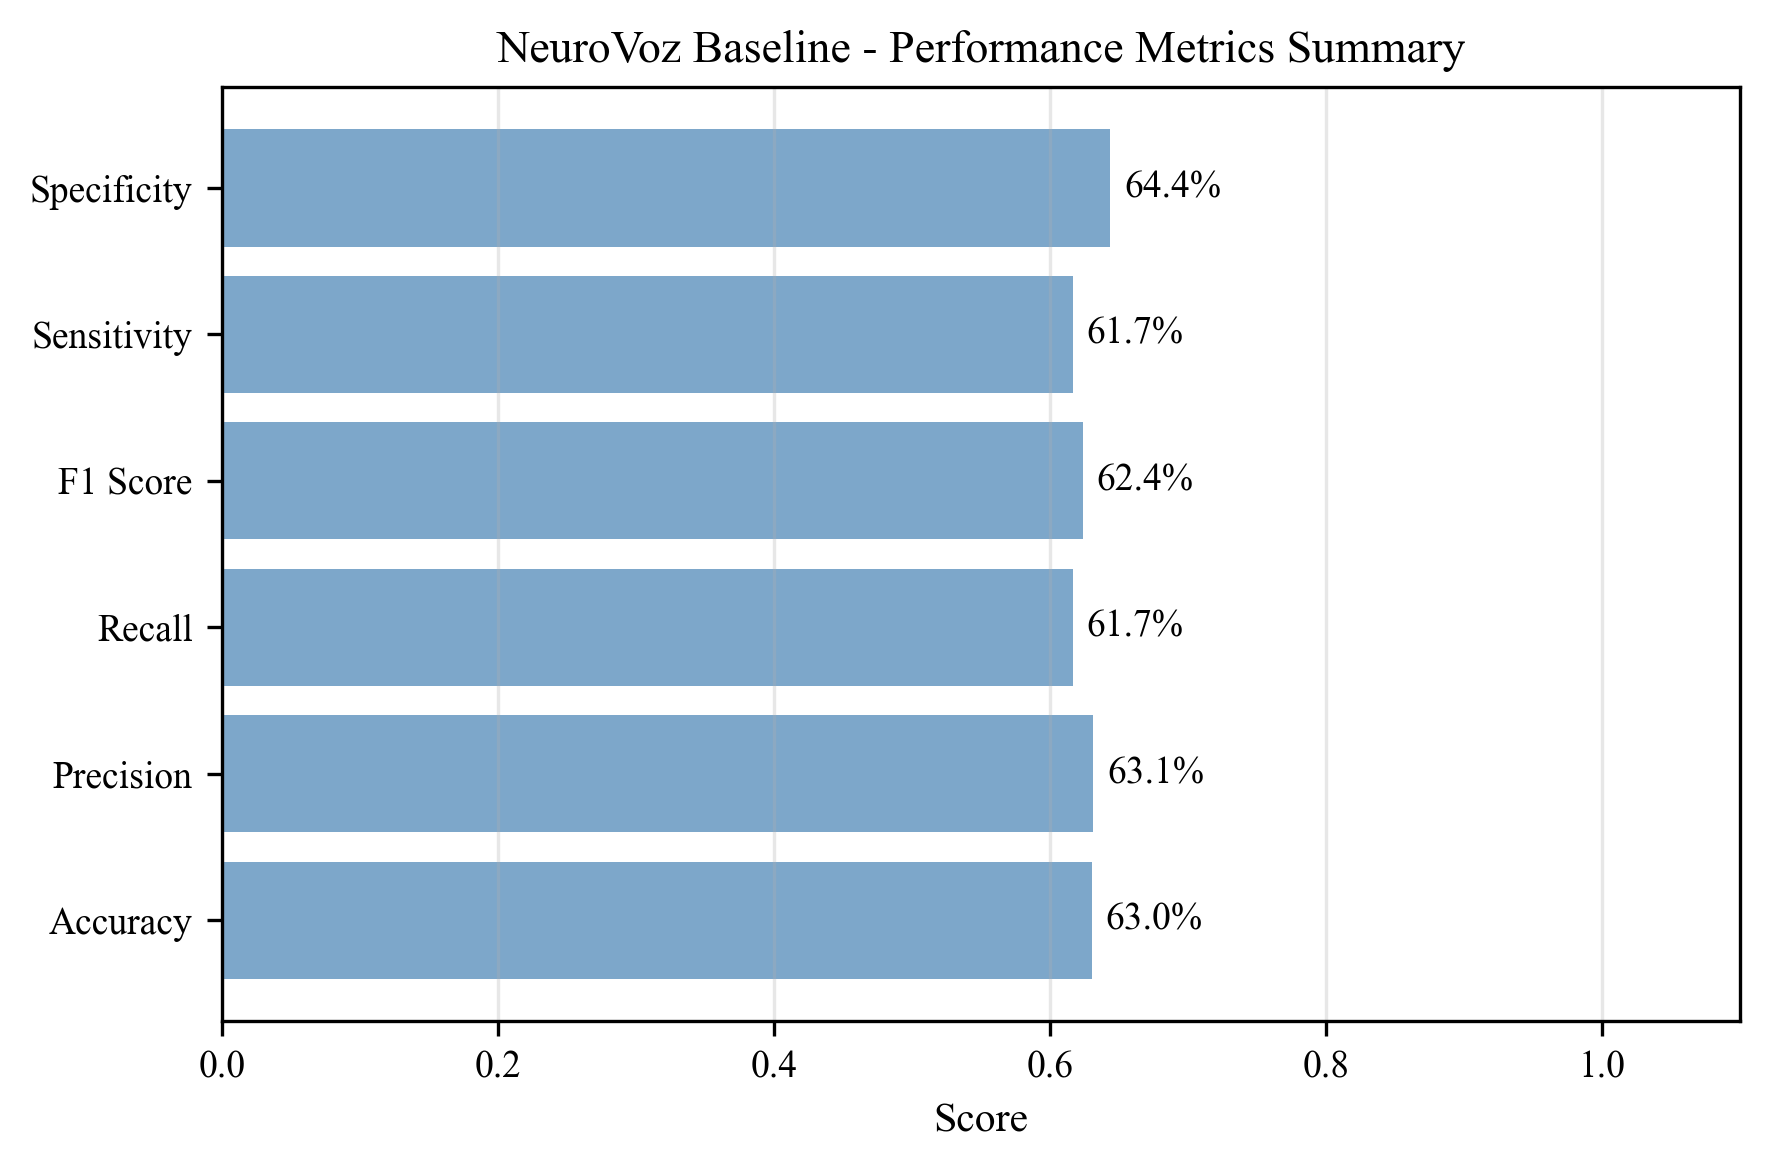

✓ saved metrics_summary.png and .pdf


In [41]:
# figure 4: performance metrics summary
print("generating figure 4: performance metrics summary...")

fig, ax = plt.subplots(figsize=(6, 4))

metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Sensitivity', 'Specificity']
metric_values = [
    metrics['accuracy'],
    metrics['precision'],
    metrics['recall'],
    metrics['f1'],
    metrics['sensitivity'],
    metrics['specificity']
]

bars = ax.barh(metric_names, metric_values, color='steelblue', alpha=0.7)

# add value labels
for i, (bar, value) in enumerate(zip(bars, metric_values)):
    ax.text(value + 0.01, i, f'{value:.1%}', 
            va='center', fontsize=9)

ax.set_xlabel('Score')
ax.set_xlim([0, 1.1])
ax.set_title('NeuroVoz Baseline - Performance Metrics Summary')
ax.grid(True, axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(config['results_dir'] / 'metrics_summary.png', dpi=300)
plt.savefig(config['results_dir'] / 'metrics_summary.pdf')
plt.show()

print(f"✓ saved metrics_summary.png and .pdf")
print("=" * 60)

## 6. save results

In [42]:
# save metrics json
print("=" * 60)
print("step 7: saving results")
print("=" * 60)

results_json = {
    'dataset': 'neurovoz',
    'task': config['task'],
    'timestamp': timestamp,
    'classifier': 'svm',
    'cv_method': 'loso',
    'metrics': metrics,
    'config': {k: str(v) if isinstance(v, Path) else v for k, v in config.items()}
}

json_path = config['results_dir'] / 'neurovoz_baseline_results.json'
with open(json_path, 'w') as f:
    json.dump(results_json, f, indent=2)

print(f"\n✓ saved results json: {json_path.name}")

step 7: saving results

✓ saved results json: neurovoz_baseline_results.json


In [43]:
# save per-subject results csv
csv_path = config['results_dir'] / 'neurovoz_subject_accuracy.csv'
subject_accuracy_df.to_csv(csv_path, index=False)

print(f"✓ saved per-subject csv: {csv_path.name}")

✓ saved per-subject csv: neurovoz_subject_accuracy.csv


In [44]:
# save classification report
report = classification_report(y, y_pred, 
                               target_names=['hc', 'pd'],
                               digits=3)

report_path = config['results_dir'] / 'classification_report.txt'
with open(report_path, 'w') as f:
    f.write("neurovoz baseline - classification report\n")
    f.write("=" * 60 + "\n\n")
    f.write(f"task: {config['task']}\n")
    f.write(f"classifier: svm (rbf kernel)\n")
    f.write(f"cv method: leave-one-subject-out\n")
    f.write(f"timestamp: {timestamp}\n\n")
    f.write(report)
    f.write("\n" + "=" * 60 + "\n")
    f.write(f"overall accuracy: {metrics['accuracy']:.1%}\n")
    f.write(f"auc-roc: {metrics['auc']:.3f}\n")

print(f"✓ saved classification report: {report_path.name}")

✓ saved classification report: classification_report.txt


In [45]:
# print completion summary
print("\n" + "=" * 60)
print("NEUROVOZ PREPROCESSING COMPLETE")
print("=" * 60)
print(f"\nresults directory: {config['results_dir']}")
print(f"\ngenerated files:")
print(f"  ├── neurovoz_baseline_results.json")
print(f"  ├── neurovoz_subject_accuracy.csv")
print(f"  ├── classification_report.txt")
print(f"  ├── confusion_matrix.png/pdf")
print(f"  ├── roc_curve.png/pdf")
print(f"  ├── per_subject_accuracy.png/pdf")
print(f"  └── metrics_summary.png/pdf")
print(f"\nbaseline performance:")
print(f"  accuracy: {metrics['accuracy']:.1%}")
print(f"  auc-roc:  {metrics['auc']:.3f}")
print(f"  f1:       {metrics['f1']:.3f}")
print(f"\n✓ ready for phase 4 cross-dataset validation!")
print("=" * 60)


NEUROVOZ PREPROCESSING COMPLETE

results directory: /Volumes/usb drive/pd-interpretability/results/neurovoz_baseline/run_20260104_204155

generated files:
  ├── neurovoz_baseline_results.json
  ├── neurovoz_subject_accuracy.csv
  ├── classification_report.txt
  ├── confusion_matrix.png/pdf
  ├── roc_curve.png/pdf
  ├── per_subject_accuracy.png/pdf
  └── metrics_summary.png/pdf

baseline performance:
  accuracy: 63.0%
  auc-roc:  0.686
  f1:       0.624

✓ ready for phase 4 cross-dataset validation!
